In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from helpers import helpfunction as helper
from helpers import plot_class
import gc

In [2]:
run=1
input_dir = "./input/16Jan/".format(run)

In [3]:
keys_true = [
    "nu_pdg",
    "nu_e",
    "lep_e",
    "true_nu_vtx_x",
    "true_nu_vtx_y",
    "true_nu_vtx_z",
    "nmuon",
    "nproton",
    "npi0",
    "npion",
    "nelec",
    "interaction",
    "weightSplineTimesTune",
    "n_pfps"
]

In [4]:
data = pickle.load(open(input_dir+"run{}_slimmed.pckl".format(run), 'rb'))

In [5]:
nue_mc = pd.DataFrame({k: data["nue"]["mc"][k] for k in keys_true})
nu_mc = pd.DataFrame({k: data["nu"]["mc"][k] for k in keys_true})

In [6]:
del data
gc.collect()

131

In [7]:
nue_mc["true_vtx_fid"] = helper.is_fid(
    nue_mc["true_nu_vtx_x"],
    nue_mc["true_nu_vtx_y"],
    nue_mc["true_nu_vtx_z"],
)
nu_mc["true_vtx_fid"] = helper.is_fid(
    nu_mc["true_nu_vtx_x"],
    nu_mc["true_nu_vtx_y"],
    nu_mc["true_nu_vtx_z"],
)

In [8]:
q_e0p = "true_vtx_fid & abs(nu_pdg)==12 & nelec==1 & nproton==0 & (npi0+npion)==0"
q_eNp = "true_vtx_fid & abs(nu_pdg)==12 & nelec==1 & nproton>0 & (npi0+npion)==0"
q_eX =  "true_vtx_fid & abs(nu_pdg)==12 & nelec==1 & (npi0+npion)>0"

new_cat = (
    nue_mc.eval(q_e0p) * 1
    + nue_mc.eval(q_eNp) * 2
    + nue_mc.eval(q_eX) * 3
)
nue_mc["category"] = new_cat

In [9]:
q_m0p = "true_vtx_fid & abs(nu_pdg)==14 & nmuon==1 & nproton==0 & (npi0+npion)==0"
q_mNp = "true_vtx_fid & abs(nu_pdg)==14 & nmuon==1 & nproton>0 & (npi0+npion)==0"
q_mX =  "true_vtx_fid & abs(nu_pdg)==14 & nmuon==1 & (npi0+npion)>0"

new_cat = (
    + nu_mc.eval(q_m0p) * 1
    + nu_mc.eval(q_mNp) * 2
    + nu_mc.eval(q_mX) * 3
)
nu_mc["category"] = new_cat

In [10]:
samples = [nu_mc, nue_mc]
s_labs = [r'$\nu_\mu$ CC ', r'$\nu_e$ CC ']

cats = {1,2,3}
c_labs = [r'0p0$\pi$', r'Np0$\pi$ (N>0)', r'NpM$\pi$ (M>0)']
field = 'nu_e'
weight = 'weightSplineTimesTune'
q_s = 'n_pfps>0'
x_min = 0.15
x_max=1.75
n_bins=8

$\nu_\mu$ CC  0p0$\pi$
23780
29372
$\nu_e$ CC  0p0$\pi$
6104
7588
$\nu_\mu$ CC  Np0$\pi$ (N>0)
113554
136841
$\nu_e$ CC  Np0$\pi$ (N>0)
27111
32487
$\nu_\mu$ CC  NpM$\pi$ (M>0)
60331
70397
$\nu_e$ CC  NpM$\pi$ (M>0)
23175
27112


/home/wouter/Documents/Jupyter/searchingfornues/helpers/plot_class.py:464: RuntimeWarning: invalid value encountered in true_divide
  eff = num_w_h / den_w_h


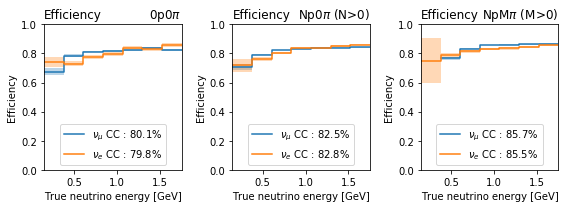

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=(8, 3))

for cat, c_lab, ax in zip(cats, c_labs, axes):
    for sample, s_lab in zip(samples, s_labs):
        num = sample.query(q_s).query("category==@cat")[field]
        den = sample.query("category==@cat")[field]
        
        print(s_lab,c_lab)
        print(len(num))
        print(len(den))
        
        num_w = sample.query(q_s).query("category==@cat")[weight]
        den_w = sample.query("category==@cat")[weight]

        eff, unc_low, unc_up, edges = plot_class.efficiency_post(
            num,
            den,
            num_w=num_w,
            den_w=den_w,
            n_bins=n_bins,
            x_min=x_min,
            x_max=x_max,
        )
        ax.fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
        ax.step(
            edges,
            eff,
            where="post",
            label="{0}: {1:.1%}".format(s_lab, sum(num_w) / sum(den_w)),
        )
    ax.set_title(c_lab, loc="right")
    ax.set_title("Efficiency", loc="left")
    ax.set_xlabel("True neutrino energy [GeV]")
    ax.set_ylabel("Efficiency")
    ax.set_ylim(0, 1)
    ax.set_xlim(x_min, x_max)
    ax.legend(loc='lower center')

fig.tight_layout()
fig.savefig("sliceID.pdf", bbox_inches="tight")

In [15]:
for sample, s_lab in zip(samples, s_labs):
    print("{0}: {1:.1%}".format(s_lab, sum(sample.query("category>0").query(q_s)[weight])/sum(sample.query("category>0")[weight])))

$\nu_\mu$ CC : 83.0%
$\nu_e$ CC : 83.3%
